# Machine Learning for Drug Discovery 2024
### Solubility
The code in this notebook is written to solve one of the problems from a hackathon at Machine Learning for Drug Discovery Summer School in Montreal in 2024. The benchmark is from polaris. Polaris is a hub for computational drug discovery benchmarks.

First, we import necessary packages. You might need to install polaris

**pip install polaris-lib**

In [1]:
from rdkit import Chem
import polaris as po
import numpy as np

One of the benchmarks from the Polaris hub for the Log solubility problem containing 1578 training and 400 test points.  It's a regression task. The info about this set can be found here: https://polarishub.io/benchmarks/polaris/adme-fang-solu-1

Before loading you might need to register by running the following command

**polaris login**

In [2]:
benchmark1 = po.load_benchmark("polaris/adme-fang-solu-1")

2024-07-09 21:58:51.590 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-07-09 21:58:51.603 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


In [3]:
train, test = benchmark1.get_train_test_split()
print (train.inputs[0])
print (train.targets[0])

CCNc1ccnc(N(C)Cc2nc3ccccc3n2C)n1
1.567849451


The descriptors/features are in the form of SMILEs and the targets are real numbers.

We will draw a few molecules from the training set

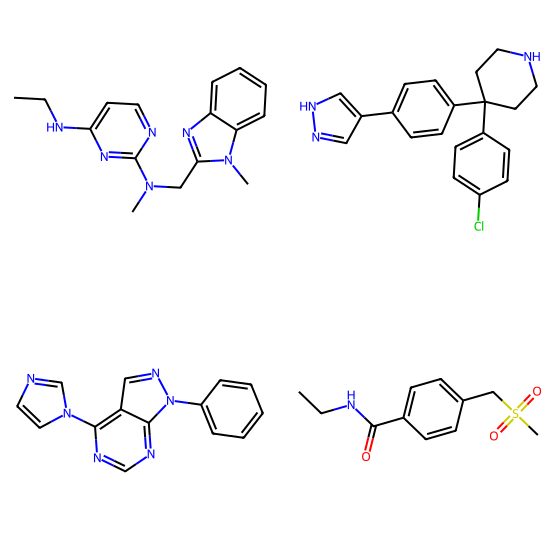

In [4]:
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(smi) for smi in train.inputs[:4]]
Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(280, 280))

We will also draw a few molecules from the test set

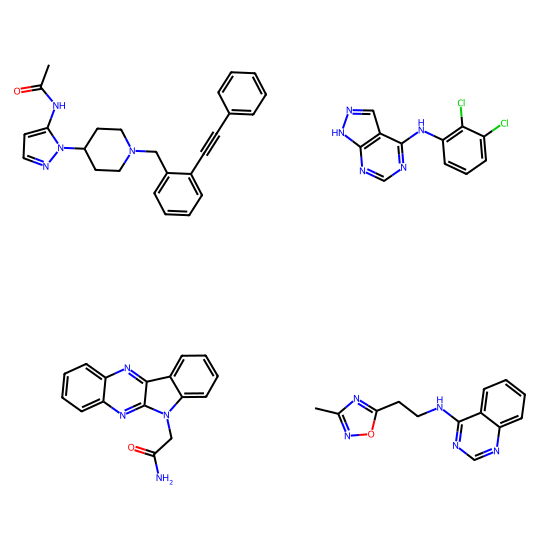

In [5]:
mols = [Chem.MolFromSmiles(smi) for smi in test.inputs[:4]]
Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(280, 280))

The training and test set molecules look quite similar.

Now we will plot the histogram of the target values from the training set. As we can see, it is quite far from the normal distribution.

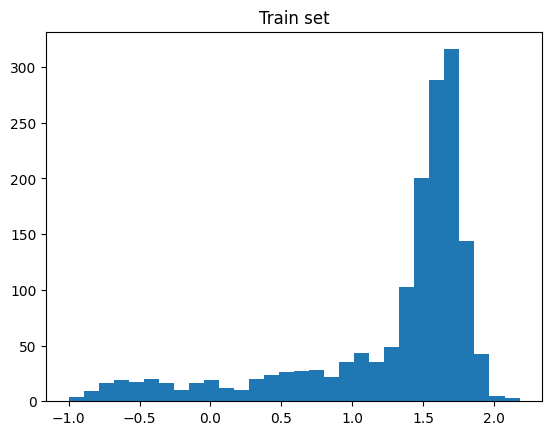

In [6]:
import matplotlib.pyplot as plt

plt.hist(train.targets, bins=30)
plt.title("Train set")
plt.show()

Let's transform it to the distribution that looks more like a normal one with the help of Box-Cox transformation.

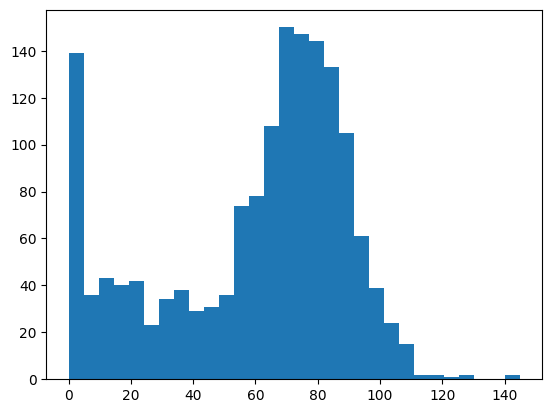

In [7]:
from scipy.stats import boxcox

z = train.targets + 2.0
bcx_target, lam = boxcox(z)
plt.hist(bcx_target, bins=30)
plt.show()

Unfortunately, we cannot plot the histogram for the test set, because within Polaris you should not need to access the targets of the test set. So, we cannot transform both sets.

Now we will turn our attention to the mordred package. This package allows us to calculate more 1800 various chemical descriptors. It can be installed by

**pip install mordred**

The description of this package is outlined in this publication: https://doi.org/10.1186/s13321-018-0258-y

The example of the code below is from here: https://schwallergroup.github.io/practical-programming-in-chemistry/tutorials/lecture_05/02_rdkit_descriptors.html


In [8]:
from mordred import Calculator, descriptors

# Create a molecule object
mol = Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")

# Create a calculator with all descriptors
calc_mordred = Calculator(descriptors, ignore_3D=True)

# Calculate descriptors for the molecule
result = calc_mordred(mol)

# Convert the result to a dictionary
descriptors_dict = result.asdict()
descriptors_dict

{'ABC': <mordred.error.Error at 0x28a833a72b0>,
 'ABCGG': <mordred.error.Error at 0x28a82f44d30>,
 'nAcid': 0,
 'nBase': 0,
 'SpAbs_A': 17.668228976605832,
 'SpMax_A': 2.504976898746481,
 'SpDiam_A': 4.932792612901734,
 'SpAD_A': 17.668228976605832,
 'SpMAD_A': 1.262016355471845,
 'LogEE_A': 3.5865898111484813,
 'VE1_A': 3.4560842310452395,
 'VE2_A': 0.24686315936037426,
 'VE3_A': 1.5766084596749432,
 'VR1_A': 57.286650373743015,
 'VR2_A': 4.091903598124501,
 'VR3_A': 4.384539855427742,
 'nAromAtom': 9,
 'nAromBond': 10,
 'nAtom': 24,
 'nHeavyAtom': 14,
 'nSpiro': 0,
 'nBridgehead': 0,
 'nHetero': 6,
 'nH': 10,
 'nB': 0,
 'nC': 8,
 'nN': 4,
 'nO': 2,
 'nS': 0,
 'nP': 0,
 'nF': 0,
 'nCl': 0,
 'nBr': 0,
 'nI': 0,
 'nX': 0,
 'ATS0dv': 248.0,
 'ATS1dv': 245.0,
 'ATS2dv': 384.0,
 'ATS3dv': 353.0,
 'ATS4dv': 278.0,
 'ATS5dv': 68.0,
 'ATS6dv': 6.0,
 'ATS7dv': 0.0,
 'ATS8dv': 0.0,
 'ATS0d': 86.0,
 'ATS1d': 105.0,
 'ATS2d': 172.0,
 'ATS3d': 167.0,
 'ATS4d': 146.0,
 'ATS5d': 92.0,
 'ATS6d': 51.0

As we can see, not all of the descriptors were successfully calculated. Some of them generated errors. There is an option to read the error in mordred.

In [9]:
print (descriptors_dict['ABC'].error)

module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


We will now calculate all available mordred descriptors for the training set and remove defected columns later. 

In [10]:
train_mols = [Chem.MolFromSmiles(smi) for smi in train.inputs]
train_descriptors = [calc_mordred(m).asdict() for m in train_mols]

Now we will convert the list with all calculated descriptors into a dataframe.

In [11]:
import pandas as pd
df_train = pd.DataFrame(train_descriptors)
df_train.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,28.598594,2.448369,4.752037,28.598594,1.299936,4.022684,...,9.942179,70.299893,296.174945,7.051784,1116,33,114.0,134.0,6.777778,4.944444
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,32.373686,2.494421,4.986597,32.373686,1.348904,4.129844,...,10.229729,72.112264,337.134575,7.662149,1322,39,130.0,156.0,5.868056,5.277778
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,27.480504,2.493041,4.866935,27.480504,1.374025,3.964251,...,9.984468,69.635041,262.096694,8.736556,779,30,110.0,133.0,4.166667,4.388889
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,18.493830,2.302776,4.605551,18.493830,1.155864,3.658211,...,9.380336,47.739468,241.077264,7.776686,492,19,76.0,82.0,7.145833,3.569444
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,27.022115,2.310771,4.621542,27.022115,1.228278,3.992775,...,9.737256,55.495412,317.093104,8.344555,1202,30,108.0,121.0,8.277778,4.888889


We can easily drop the columns with NaNs.

In [12]:
df_train_no_nan = df_train.select_dtypes(include=[np.number])
df_train_no_nan.head()

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,0,28.598594,2.448369,4.752037,28.598594,1.299936,4.022684,3.793352,0.172425,...,9.942179,70.299893,296.174945,7.051784,1116,33,114.0,134.0,6.777778,4.944444
1,0,1,32.373686,2.494421,4.986597,32.373686,1.348904,4.129844,4.170329,0.173764,...,10.229729,72.112264,337.134575,7.662149,1322,39,130.0,156.0,5.868056,5.277778
2,0,0,27.480504,2.493041,4.866935,27.480504,1.374025,3.964251,3.954656,0.197733,...,9.984468,69.635041,262.096694,8.736556,779,30,110.0,133.0,4.166667,4.388889
3,0,0,18.493830,2.302776,4.605551,18.493830,1.155864,3.658211,3.627381,0.226711,...,9.380336,47.739468,241.077264,7.776686,492,19,76.0,82.0,7.145833,3.569444
4,0,0,27.022115,2.310771,4.621542,27.022115,1.228278,3.992775,4.211881,0.191449,...,9.737256,55.495412,317.093104,8.344555,1202,30,108.0,121.0,8.277778,4.888889


There are now 1369 columns instead of 1613.

Let's do the same with the test set. First, we will calculate all descriptors.

In [13]:
test_mols = [Chem.MolFromSmiles(smi) for smi in test.inputs]
test_descriptors = [calc_mordred(m).asdict() for m in test_mols]

Now we convert the list with the calculated descriptors into a dataframe.

In [14]:
df_test = pd.DataFrame(test_descriptors)
df_test.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,39.479928,2.392671,4.740418,39.479928,1.315998,4.328044,...,10.132494,78.901677,398.210661,7.110905,2873,42,154.0,177.0,7.888889,6.666667
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,23.703858,2.415055,4.777163,23.703858,1.316881,3.839524,...,9.829357,64.892957,279.007851,11.160314,593,27,96.0,114.0,5.166667,3.944444
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,28.183162,2.560589,4.961345,28.183162,1.342055,4.013210,...,10.187500,70.173499,276.101111,8.366700,833,36,118.0,144.0,5.638889,4.500000
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,25.185002,2.372924,4.744123,25.185002,1.325526,3.882571,...,9.714323,65.653630,255.112010,7.972250,781,25,98.0,113.0,4.805556,4.222222
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,24.876389,2.388048,4.776097,24.876389,1.243819,3.909823,...,9.873698,53.578765,336.046604,8.843332,861,30,102.0,117.0,7.868056,4.402778


We can see, that there are also 1613 columns. Let's drop the columns with NaNs.

In [15]:
df_test_no_nan = df_test.select_dtypes(include=[np.number])
df_test_no_nan.head()

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,1,39.479928,2.392671,4.740418,39.479928,1.315998,4.328044,4.412202,0.147073,...,10.132494,78.901677,398.210661,7.110905,2873,42,154.0,177.0,7.888889,6.666667
1,0,0,23.703858,2.415055,4.777163,23.703858,1.316881,3.839524,3.892436,0.216246,...,9.829357,64.892957,279.007851,11.160314,593,27,96.0,114.0,5.166667,3.944444
2,0,0,28.183162,2.560589,4.961345,28.183162,1.342055,4.013210,3.982189,0.189628,...,10.187500,70.173499,276.101111,8.366700,833,36,118.0,144.0,5.638889,4.500000
3,0,0,25.185002,2.372924,4.744123,25.185002,1.325526,3.882571,3.658815,0.192569,...,9.714323,65.653630,255.112010,7.972250,781,25,98.0,113.0,4.805556,4.222222
4,0,1,24.876389,2.388048,4.776097,24.876389,1.243819,3.909823,4.020435,0.201022,...,9.873698,53.578765,336.046604,8.843332,861,30,102.0,117.0,7.868056,4.402778


As we can see, the number of columns is now different from the training set dataframe. So, we should use another approach. We will first detect all columns in both dataframes with NaN with the help of the following function.

In [16]:
is_number = np.vectorize(lambda x: np.issubdtype(x, np.number))

Now we apply is_number to the training set.

In [17]:
nan_train = is_number(df_train.dtypes)

print ("The columns with NaNs are marked with False")
print (nan_train)

nan_idx_train = set(np.where(nan_train == False)[0])

print ("\nThe indices of columns with NaNs")
print (nan_idx_train)
print ("\nThe number of columns with NaNs")
print (len(nan_idx_train))

The columns with NaNs are marked with False
[False False  True ...  True  True  True]

The indices of columns with NaNs
{0, 1, 512, 520, 528, 536, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 544, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 552, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 560, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 568, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 576, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 584, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 592, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 600, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 608, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 616, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 624, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 632, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 640, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 142, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 151, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 160, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 169, 

Now we apply is_number to the test set.

In [18]:
nan_test = is_number(df_test.dtypes)

print ("The columns with NaNs are marked with False")
print (nan_test)

nan_idx_test = set(np.where(nan_test == False)[0])

print ("\nThe indices of columns with NaNs")
print (nan_idx_test)
print ("\nThe number of columns with NaNs")
print (len(nan_idx_test))

The columns with NaNs are marked with False
[False False  True ...  True  True  True]

The indices of columns with NaNs
{0, 1, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 119

Now we unite both the training and test sets of columns with NaNs.

In [19]:
nan_idx_train_test = list(nan_idx_train.union(nan_idx_test))
print (len(nan_idx_train_test))

244


Drop the united columns with NaNs from the training set dataframe.

In [20]:
df_train_clean = df_train.drop(df_train.columns[nan_idx_train_test], axis=1)
df_train_clean.head()

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,0,28.598594,2.448369,4.752037,28.598594,1.299936,4.022684,3.793352,0.172425,...,9.942179,70.299893,296.174945,7.051784,1116,33,114.0,134.0,6.777778,4.944444
1,0,1,32.373686,2.494421,4.986597,32.373686,1.348904,4.129844,4.170329,0.173764,...,10.229729,72.112264,337.134575,7.662149,1322,39,130.0,156.0,5.868056,5.277778
2,0,0,27.480504,2.493041,4.866935,27.480504,1.374025,3.964251,3.954656,0.197733,...,9.984468,69.635041,262.096694,8.736556,779,30,110.0,133.0,4.166667,4.388889
3,0,0,18.493830,2.302776,4.605551,18.493830,1.155864,3.658211,3.627381,0.226711,...,9.380336,47.739468,241.077264,7.776686,492,19,76.0,82.0,7.145833,3.569444
4,0,0,27.022115,2.310771,4.621542,27.022115,1.228278,3.992775,4.211881,0.191449,...,9.737256,55.495412,317.093104,8.344555,1202,30,108.0,121.0,8.277778,4.888889


Drop the united columns with NaNs from the test set dataframe.

In [21]:
df_test_clean = df_test.drop(df_test.columns[nan_idx_train_test], axis=1)
df_test_clean.head()

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,1,39.479928,2.392671,4.740418,39.479928,1.315998,4.328044,4.412202,0.147073,...,10.132494,78.901677,398.210661,7.110905,2873,42,154.0,177.0,7.888889,6.666667
1,0,0,23.703858,2.415055,4.777163,23.703858,1.316881,3.839524,3.892436,0.216246,...,9.829357,64.892957,279.007851,11.160314,593,27,96.0,114.0,5.166667,3.944444
2,0,0,28.183162,2.560589,4.961345,28.183162,1.342055,4.013210,3.982189,0.189628,...,10.187500,70.173499,276.101111,8.366700,833,36,118.0,144.0,5.638889,4.500000
3,0,0,25.185002,2.372924,4.744123,25.185002,1.325526,3.882571,3.658815,0.192569,...,9.714323,65.653630,255.112010,7.972250,781,25,98.0,113.0,4.805556,4.222222
4,0,1,24.876389,2.388048,4.776097,24.876389,1.243819,3.909823,4.020435,0.201022,...,9.873698,53.578765,336.046604,8.843332,861,30,102.0,117.0,7.868056,4.402778


We will now convert both dataframes to numpy arrays that will be used as our features in statistical models.

In [22]:
train_X = df_train_clean.to_numpy()
test_X = df_test_clean.to_numpy()

print (train_X.shape)
print (test_X.shape)

(1578, 1369)
(400, 1369)


Below is the code for the fitting our data with the Gradient Boosting Decision Trees algorithm, which returns the R2 score. It accepts three hyperparameters: the number of estimators, the max depth of trees and the learning rate as well as the random state.

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing

def GBoost_r2(train_X, train_y, test_X, n_est, max_d, learn_r, rand_st):
    model = GradientBoostingRegressor(n_estimators=n_est, max_depth=max_d, learning_rate=learn_r, random_state=rand_st)
    scaler_X = preprocessing.StandardScaler().fit(train_X)

    X_train_scaled = scaler_X.transform(train_X)
    X_test_scaled = scaler_X.transform(test_X)
    
    model.fit(X_train_scaled, train_y)

    y_pred = model.predict(X_test_scaled)

    results = benchmark1.evaluate(y_pred)

    for k, item in enumerate(results.results['Metric']):
        if str(item) == 'Metric.r2':
            return results, results.results['Score'][k]
    return results, None

Here is an example for 30 estimators, max depth of 5 and learning rate 0.12.

In [24]:
mgb, r2_score_mgb = GBoost_r2(train_X, train.targets, test_X, 30, 5, 0.12, 777)
print (30, 5, 0.12, r2_score_mgb)

30 5 0.12 0.28808494167580134


It might not be the best result. Therefore, the hyperparameters need to be optimized. Below is a simple genetic algorithm for the optimization of hyperparameters of the Gradient Boosting model. Since, it is quite slow in Jupyter notebook, we use here population_size = 4 and 5 steps of genetic algorithm.

In [25]:
def GA_for_GBoost_r2(train_X, train_y, test_X, population_size = 4, n_steps = 5, to_print = False):
    # hyperparameters
    npop = population_size
    n_estimators_1 = 15
    n_estimators_2 = 150
    max_depth_1 = 3
    max_depth_2 = 12
    learning_rate_1 = -0.6 # it will be used as an exponent
    learning_rate_2 = -1.6 # it will be used as an exponent

    estimators_limits = (5, 200)
    depth_limits = (2, 20)
    learning_rate_limits = (-2.0, 0.0)

    # calculate initial score
    _, score1 = GBoost_r2(train_X, train_y, test_X, n_estimators_1, max_depth_1, 10**learning_rate_1, 777)
    _, score2 = GBoost_r2(train_X, train_y, test_X, n_estimators_2, max_depth_2, 10**learning_rate_2, 777)

    best_value = max(score1, score1)
    r2_list = list()

    if score1 > score2:
        r2_list.append((score2, max_depth_2, n_estimators_2, learning_rate_2))
        r2_list.append((score1, max_depth_1, n_estimators_1, learning_rate_1))
    else:
        r2_list.append((score1, max_depth_1, n_estimators_1, learning_rate_1))
        r2_list.append((score2, max_depth_2, n_estimators_2, learning_rate_2))

    # start the optimization
    for i in range(n_steps):
        print('iter %d. reward: %f' % (i, best_value))

        pop_estimators = generate_population(n_estimators_1, n_estimators_2, estimators_limits, npop)
        pop_depth = generate_population(max_depth_1, max_depth_2, depth_limits, npop)
        pop_learning_rate = generate_population(learning_rate_1, learning_rate_2, learning_rate_limits, npop)

        R = np.zeros(npop)
        for j in range(npop):
            _, R[j] = GBoost_r2(train_X, train_y, test_X, pop_estimators[j], pop_depth[j], 10**pop_learning_rate[j], 777)
            if to_print: print (j, pop_estimators[j], pop_depth[j], 10**pop_learning_rate[j], R[j])

        Z = [(x, y, z) for _, x, y, z in sorted(zip(R, pop_estimators, pop_depth, pop_learning_rate), key=lambda pair: pair[0])]

        n_estimators_1 = Z[-1][0]
        n_estimators_2 = Z[-2][0]

        max_depth_1 = Z[-1][1]
        max_depth_2 = Z[-2][1]

        learning_rate_1 = Z[-1][2]
        learning_rate_2 = Z[-2][2]

        if np.max(R) > best_value:
            best_value = np.max(R)
            r2_list.append((best_value, n_estimators_1, max_depth_1, learning_rate_1))
        else:
            n_estimators_2 = r2_list[-1][1]
            max_depth_2 = r2_list[-1][2]
            learning_rate_2 = r2_list[-1][3]

    return best_value, r2_list

We need to generate a population for the genetic algorithm. We will do it based on two "parents" and also randomly apply mutations. If the parents are integers, the population will also consits of integer numbers.

In [26]:
import random

def generate_population(parent1, parent2, limits, npop):
    population = []

    for k in range(npop):
        p = random.random()
        mated_val = parent1 * p + parent2 * (1 - p)
            
        if random.random() < 0.2:
            mated_val = mated_val * (0.7 + 0.6 * random.random())
                
        if mated_val < limits[0]:
            mated_val = limits[0]
        elif mated_val > limits[1]:
            mated_val = limits[1]

        if isinstance(parent1, int) and isinstance(parent2, int):
            mated_val = int(mated_val)
                
        child = mated_val

        population.append(child)
       
    return population

In [27]:
best_value, r2score_list = GA_for_GBoost_r2(train_X, train.targets, test_X, to_print = False)

iter 0. reward: 0.241403
iter 1. reward: 0.254962
iter 2. reward: 0.302270
iter 3. reward: 0.311809
iter 4. reward: 0.311809


In [28]:
print (r2score_list[-1])

(0.31180939680341435, 97, 3, -0.9854720598692671)


Now we rerun `GBoost_r2` with the optimized hyperparameters.

In [29]:
mgb, r2_score_mgb = GBoost_r2(train_X, train.targets, test_X, r2score_list[-1][1], r2score_list[-1][2], 10**r2score_list[-1][3], 777)
print (r2score_list[-1][1], r2score_list[-1][2], 10**r2score_list[-1][3], r2_score_mgb)
print (mgb)

97 3 0.103401762187874 0.31180939680341435
name=None description='' tags=[] user_attributes={} owner=None polaris_version='dev' results=  Test set    Target label                      Metric     Score
0     test  LOG_SOLUBILITY  Metric.mean_absolute_error  0.420954
1     test  LOG_SOLUBILITY   Metric.mean_squared_error  0.373122
2     test  LOG_SOLUBILITY                   Metric.r2  0.311809
3     test  LOG_SOLUBILITY            Metric.spearmanr  0.453398
4     test  LOG_SOLUBILITY             Metric.pearsonr  0.559741
5     test  LOG_SOLUBILITY        Metric.explained_var  0.313178 benchmark_name='adme-fang-SOLU-1' benchmark_owner=HubOwner(slug='polaris', external_id='org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu', type='organization') github_url=None paper_url=None contributors=None artifact_id=None benchmark_artifact_id='polaris/adme-fang-solu-1'


Since the GA might not yield the best results with such a small population, we will run `GBoost_r2` with the previously obtained best parameters for a larger population.

In [30]:
n_est, max_d, learn_r = 95, 4, -0.9123646

mgb, r2_score_mgb = GBoost_r2(train_X, train.targets, test_X, n_est, max_d, 10**learn_r, 777)

print (n_est, max_d, 10**learn_r, r2_score_mgb)
print (mgb)

95 4 0.12235885378142272 0.34018161161456184
name=None description='' tags=[] user_attributes={} owner=None polaris_version='dev' results=  Test set    Target label                      Metric     Score
0     test  LOG_SOLUBILITY  Metric.mean_absolute_error  0.410583
1     test  LOG_SOLUBILITY   Metric.mean_squared_error  0.357739
2     test  LOG_SOLUBILITY                   Metric.r2  0.340182
3     test  LOG_SOLUBILITY            Metric.spearmanr  0.482510
4     test  LOG_SOLUBILITY             Metric.pearsonr  0.584221
5     test  LOG_SOLUBILITY        Metric.explained_var  0.341031 benchmark_name='adme-fang-SOLU-1' benchmark_owner=HubOwner(slug='polaris', external_id='org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu', type='organization') github_url=None paper_url=None contributors=None artifact_id=None benchmark_artifact_id='polaris/adme-fang-solu-1'


## Conclusion

The best results for the **Gradient Boosting Decision Trees** algorithm and **mordred** descriptors, **R2 = 0.340182**, are obtained with the following hyperparameters: n_estimators = 95, max_depth = 4, learning_rate = 0.12235885378142272 (or 10^-0.9123646).

For comparison, the combination of **Gradient Boosting Decision Trees** and **RDKit** descriptors yields for this task **R2 = 0.329254**.

We will combine in the next file **mordred** and **RDKit** descriptors, but will use XGBoost for faster performance.